In [1]:
%%capture

!pip install parsivar

In [2]:
# Download the dataset

%%capture

! rm -rf *
! gdown --id 1l3gymRj-or40zAOFA09ETo3kHtA-5PeG

! unzip comments.zip
! rm comments.zip

In [3]:
import requests
from string import punctuation

import pandas as pd 
import numpy as np 

import seaborn as sns 
import matplotlib.pyplot as plt 

from parsivar import Tokenizer, Normalizer, FindStems

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import confusion_matrix, f1_score, classification_report, roc_curve, roc_auc_score, accuracy_score


In [4]:
train = pd.read_csv('./comments/train.csv', encoding='utf-8')
test = pd.read_csv('./comments/test.csv', encoding='utf-8')
train.drop('date', axis=1, inplace=True)

In [6]:
tokenizer = Tokenizer()
normalizer = Normalizer()
stemmer = FindStems()
my_punctuation = punctuation + '،"؛«»)\('

def normalize_text (text) :
    tokens = tokenizer.tokenize_words(text)
    tokens = [stemmer.convert_to_stem(word).split('&')[0] for word in tokens]
    text = ' '.join([word for word in tokens if word not in list(my_punctuation)])
    
    return text

In [7]:
vectorizer = TfidfVectorizer(max_features=300, preprocessor=normalize_text, use_idf=True).fit(train.comment)

In [8]:
vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['آب',
 'آن',
 'آوردن',
 'ارسال',
 'از',
 'اس',
 'است',
 'استفاده',
 'اسنپ',
 'اش',
 'اشتباه',
 'اصلا',
 'اضافه',
 'افتضاح',
 'البته',
 'العاده',
 'اما',
 'امیدوار',
 'انتظار',
 'اندازه',
 'انقدر',
 'انگار',
 'اول',
 'اولین',
 'اومد',
 'اون',
 'اگر',
 'اگه',
 'ای',
 'این',
 'اینجا',
 'اینکه',
 'با',
 'بابت',
 'بار',
 'باز',
 'باشه',
 'بالا',
 'باید',
 'بجا',
 'بد',
 'بدون',
 'بدی',
 'بر',
 'برام',
 'برای',
 'برخورد',
 'برنج',
 'برگر',
 'بستنی',
 'بسته',
 'بسیار',
 'بشه',
 'بعد',
 'بقیه',
 'بند',
 'به',
 'بهتر',
 'بهترین',
 'بود',
 'بودم',
 'بودن',
 'بوده',
 'بوی',
 'بی',
 'بیات',
 'بیشتر',
 'تا',
 'تاخیر',
 'تاریخ',
 'تازه',
 'تحویل',
 'تشکر',
 'تقریبا',
 'تماس',
 'تمام',
 'تند',
 'ته',
 'تو',
 'توجه',
 'توضیحات',
 'تومن',
 'توی',
 'تکه',
 'تیکه',
 'جا',
 'جالب',
 'جای',
 'جعبه',
 'جوجه',
 'حال',
 'حتی',
 'حجم',
 'حد',
 'خام',
 'خامه',
 'خرید',
 'خشک',
 'خمیر',
 'خواست',
 'خوب',
 'خوبه',
 'خوبی',
 'خود',
 'خورد',
 'خوردن',
 'خورده',
 'خوش',
 'خوشمزه',
 'خیلی',
 'داخل',
 'داد',
 'داده',

In [9]:
'است' in vectorizer.get_feature_names_out()

True

In [10]:
train_vectors = vectorizer.transform(train.comment)

cluster_model = KMeans(n_clusters=2, random_state=313, n_init = 100)
cluster_model.fit(train_vectors)

KMeans(n_clusters=2, n_init=100, random_state=313)

In [11]:
train['cluster'] = 1 - cluster_model.labels_

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


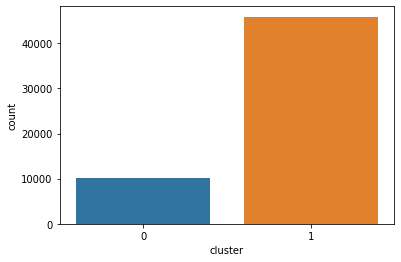

In [12]:
sns.countplot(train.cluster)

In [13]:
x_train,x_test , y_train,y_test = train_test_split(train_vectors, train.cluster, random_state=313, stratify=train.cluster, test_size=0.2)

In [14]:
model = RandomForestClassifier(n_jobs=-1, n_estimators=45, random_state=313, class_weight='balanced')
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
y_pred_prob = model.predict_proba(x_test)


In [15]:
print(f"f1-score = {f1_score(y_test, y_pred)}")
print(f"accuracy = {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

f1-score = 0.9858772406300923
accuracy = 0.9767857142857143
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      2026
           1       0.98      0.99      0.99      9174

    accuracy                           0.98     11200
   macro avg       0.97      0.95      0.96     11200
weighted avg       0.98      0.98      0.98     11200



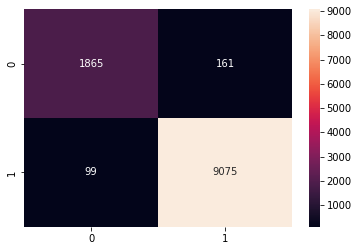

In [24]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,fmt='g')

0.9973013512370575


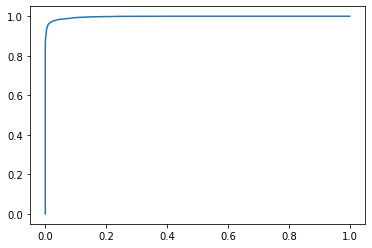

In [17]:
print(roc_auc_score(y_test, y_pred_prob[:,1]))
fpr, tpr, thres = roc_curve(y_test, y_pred_prob[:,1])
plt.plot(fpr, tpr)

In [18]:
test_vectors = vectorizer.transform(test.comment)

In [19]:
y_test_pred = model.predict(test_vectors)
y_test_prob = model.predict_proba(test_vectors)

In [20]:
output = pd.DataFrame()
output['prediction'] = y_test_prob[:,1]
output

,prediction
0,1.000000
1,0.977778
2,0.977778
3,1.000000
4,0.933333
...,...
13995,0.066667
13996,1.000000
13997,0.822222
13998,0.000000


In [21]:
output.shape

(14000, 1)

In [22]:
output.to_csv('./output.csv', index=False)